In [13]:
#Libraries
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

In [14]:
#GPU Checking
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("GPU is not available. Using CPU.")

Using GPU: NVIDIA GeForce RTX 3060


In [15]:
#Grabbing Datasets
hd_train = pd.read_csv('./datasets/house-train.csv')

#Grab Feature Columns
feature_cols = ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF',
            'FullBath', 'YearBuilt', 'YearRemodAdd', 'Fireplaces',
            'LotFrontage','WoodDeckSF','OpenPorchSF',
            'ExterQual','Neighborhood','MSZoning',
            'Alley','LotShape','LandContour','Condition1','HouseStyle',
            'MasVnrType','SaleCondition',]

encode_cols = ['Neighborhood','MSZoning','Alley','LotShape','LandContour','Condition1','HouseStyle','MasVnrType','SaleCondition']

hd = pd.get_dummies(hd_train, columns= encode_cols)
hd = hd_train.replace({True: 1, False: 0})



features = hd[encode_cols].copy()
target = hd_train['SalePrice'].values.reshape(-1,1)

#Convert to floats and handle NaN values + scaling
features = features.apply(pd.to_numeric, errors='coerce').fillna(0)
features = StandardScaler().fit_transform(features)

In [16]:
#Train-Test Split
x_train, x_val, y_train, y_val = train_test_split(features, target, test_size= 0.2, random_state= 0)

#training tensors
x_trainT = torch.tensor(x_train, dtype=torch.float32)
y_trainT = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

#Validation Tensors
x_valT = torch.tensor(x_val, dtype=torch.float32)
y_valT = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

In [17]:
#Data Loaders
train_dataset = TensorDataset(x_trainT, y_trainT)
valid_dataset = TensorDataset(x_valT, y_valT)

training_loader = DataLoader(dataset= train_dataset, batch_size= 16, shuffle= True)
valid_loader = DataLoader(dataset= valid_dataset, batch_size= 16, shuffle= False)


In [18]:
#Training Loop + Empty Arrays for storing Training and Validation Results
train_loss_list = []
val_loss_list = []

val_accuracy_list = []
all_predicted = []
all_labels = []

#Regression TL
def TL(n_epochs, optimizer, model, loss_fn, training_loader, valid_loader):
  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0
    model.train()
    for inputs, targets in training_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = loss_fn(outputs, targets)
      loss.backward()
      optimizer.step()
      loss_train += loss.item() * inputs.size(0)

    loss_train /= len(training_loader.dataset)
    train_loss_list.append(loss_train) 

    
    #Validation Loop
    model.eval()
    total = 0.0
    valid_loss = 0.0
    
    with torch.no_grad():
      for inputs, labels in valid_loader:
          inputs = inputs.to(device)
          labels = labels.to(device)
          outputs = model(inputs)
          loss = loss_fn(outputs, labels)
          valid_loss += loss.item() * inputs.size(0)
          total += ((outputs - labels) ** 2).sum().item()
          

          
    valid_loss /= len(valid_loader.dataset)
    val_loss_list.append(valid_loss)
    rmse = np.sqrt(total / len(valid_loader.dataset))

    if epoch == 1 or epoch % 5 == 0: 
      print('Epoch: {}, Training Loss: {}, Validation Loss: {}, RMSE: {}'.format(epoch, loss_train / len(training_loader), valid_loss / len(valid_loader), rmse))
  

Problem 2B - One-Hot encoding

In [19]:
#Model
class RegressionNet(nn.Module):
    def __init__(self):
        super(RegressionNet, self).__init__()
        self.fc1 = nn.Linear(9, 256)  # 6 input features
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64,32)
        self.fc4 = nn.Linear(32, 1)  # Output layer with 2 units for width and height

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [20]:
#Training
model = RegressionNet().to(device)
a = 0.001
epochs = 100
lossFN = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr= a)

TL(
  n_epochs= epochs,
  optimizer= optimizer,
  model= model,
  loss_fn= lossFN,
  training_loader= training_loader,
  valid_loader= valid_loader,
)

Epoch: 1, Training Loss: 532156450.97241503, Validation Loss: 2094464616.4671953, RMSE: 199486.40984507368
Epoch: 5, Training Loss: 479871612.4210921, Validation Loss: 1788571987.6106706, RMSE: 184344.42699632322
Epoch: 10, Training Loss: 97171607.95946707, Validation Loss: 380784548.4527758, RMSE: 85058.25310105269
Epoch: 15, Training Loss: 84393275.35222368, Validation Loss: 363473662.70800287, RMSE: 83102.34407916575
Epoch: 20, Training Loss: 84487759.00018765, Validation Loss: 363511343.9884643, RMSE: 83106.6515736305
Epoch: 25, Training Loss: 84398320.93976355, Validation Loss: 363542612.90266764, RMSE: 83110.22587594553
Epoch: 30, Training Loss: 84402493.89829236, Validation Loss: 363469368.8478731, RMSE: 83101.85321705882
Epoch: 35, Training Loss: 84393297.33008069, Validation Loss: 363465778.57245857, RMSE: 83101.4427845673
Epoch: 40, Training Loss: 84393366.45824733, Validation Loss: 363480032.9920692, RMSE: 83103.07230692085
Epoch: 45, Training Loss: 84446709.19121787, Valida

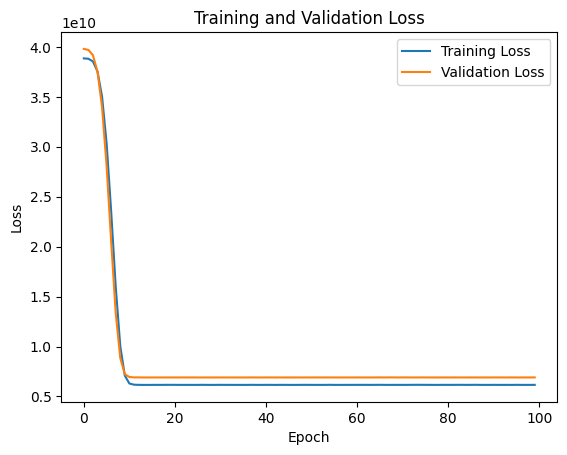

In [21]:
# Plotting training and validation loss
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# I tweaked the model and that fixed the overfitting, so it did get better compared to 2A
# instead of worse as I stated in the report!